In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import sys
sys.path.append('..')
from src.preprocessing_sensor import DataPreprocessing
from src.data_models import DataModels

## Read & Preprocess

In [2]:
DATA_DIR = "../data/raw"

DATE = "_06_06_22"
PURPLE_PATH = f"{DATA_DIR}/purple{DATE}.csv"
AIRE_PATH = f"{DATA_DIR}/aire{DATE}.csv"

dp = DataPreprocessing(PURPLE_PATH, AIRE_PATH)
dp.preprocess()

purple, aire = dp.get_data()
data = DataModels(purple, aire)

## Helper Funcs

In [3]:
def evaluate_model(X, y, model):
	cv = KFold(n_splits=5, shuffle=True)
	scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error', 'r2'], cv=cv, n_jobs=-1)
	return scores


def run_models(X,y):
	""" Para los datos X,y de un municipio, correr evaluate_models con cada modelo """
	models, _ = get_models()
	validation_results = list()
	for model in models:
		
		# Evaluate
		scores = evaluate_model(X, y, model)
		validation_results.append(scores)

	return validation_results


def convert_results(cv_results):
	"""
	Convertir los resultados de cross_validate a formato list para pandas.
	cv_results: Lista de dict, cada dict representa un modelo, cada key del dict es una metrica(i.e
				mse, r^2 ...), para cada métrica hay un list de valores, cada valor representa un cv.

	cv_results: [{mse:[10.0, 5.0, ...], r^2:[0.85, 0.8 ...]},
				 {mse: []}, 
				  ...  ]
	"""
	# Obtener lista de mse por modelo (Para el Boxplot)
	cv_scores = [np.abs(model_res['test_neg_mean_squared_error']) for model_res in cv_results]

	# Obtener promedio de todos valores en la lista de cada métrica para cada modelo
	for dict_ in cv_results:
		for key, values in dict_.items():
			dict_[key] = abs(np.mean(values))

	return cv_results, cv_scores


def run_municipios(municipios):
	""" Dada una lista de municipios, obtener los datos a partir del objeto Preprocessing y correr run_models """
	df_mun = pd.DataFrame()
	list_cv_scores = list()
	_, names = get_models()

	for municipio in municipios:
		municipio_str = ', '.join(municipio)

		X, y = data.get_municipio(municipio)

		cv_results = run_models(X,y)
		cv_mean, cv_scores = convert_results(cv_results)

		index = pd.MultiIndex.from_tuples(zip([municipio_str]*(len(names)), names))

		df_mun = pd.concat([df_mun, pd.DataFrame(cv_mean, index=index)], axis = 0)
		list_cv_scores.append(cv_scores)

	return df_mun, list_cv_scores

In [4]:
class BaseModel(BaseEstimator):

    def __init__(self):
        pass

    def fit(self,X,y):
        return self

    def predict(self, X):
        return (X['PM25_A'] + X['PM25_B'])/2

In [5]:
# define models to test
def get_models():
	models, names = list(), list()

	# Base Model
	models.append(BaseModel())
	names.append('Base')
	
	# Linear Reg
	models.append(LinearRegression())
	names.append('Linear Reg')

	#Polynomial Reg
	polynomial_pipe = Pipeline(steps=
								[('poly_features', PolynomialFeatures(degree=2)),
								('model', LinearRegression())])
	models.append(polynomial_pipe)
	names.append('Poly Reg 2')

	# #Polynomial Reg
	# polynomial_pipe = Pipeline(steps=
	# 							[('poly_features', PolynomialFeatures(degree=2)),
	# 							('model', LinearRegression())])
	# models.append(polynomial_pipe)
	# names.append('Polynomial Reg 3')
	
	# RF
	models.append(RandomForestRegressor())
	names.append('RandomForest')

	# #KNR
	# models.append(KNeighborsRegressor())
	# names.append('KNeighborsR')

	# # XGBOOST
	# models.append(xgb.XGBRegressor())
	# names.append('XGBooster')

	
	return models, names

## run_models con los municipios

In [6]:
municipios = []

In [7]:
df_mun, cv_scores = run_municipios(municipios)
df_res = df_mun[['test_neg_mean_squared_error', 'test_r2']]
df_res.columns=['MSE', 'r2']

In [8]:
df_res = df_res.rename(index={'M1, M2, M3, M4, M5, M6': 'All'})
df_res

MSE        r2
San Pedro      Base          117.032236  0.017199
               Linear Reg     33.278102  0.711221
               Poly Reg 2     30.103355  0.738151
               RandomForest   27.124360  0.763858
Santa Catarina Base          176.297220  0.636520
               Linear Reg    133.802713  0.727557
               Poly Reg 2    112.302291  0.768769
               RandomForest   96.391889  0.801860
Cadereyta      Base           66.289450  0.637909
               Linear Reg     48.291730  0.742678
               Poly Reg 2     45.827110  0.756339
               RandomForest   44.925362  0.757727
Obispado       Base          128.937086  0.154645
               Linear Reg     66.848031  0.563677
               Poly Reg 2     45.335714  0.703804
               RandomForest   37.083312  0.757660
Juarez         Base          396.998358  0.385909
               Linear Reg    238.023362  0.633509
               Poly Reg 2    239.393445  0.633565
               RandomForest  166.554157  0.743651
Apodaca        Base          149.300286  0.254401
               Linear Reg     64.433106  0.679019
               Poly Reg 2     61.027399  0.695781
               RandomForest   53.770173  0.729850
Todos          Base          173.961929  0.517744
               Linear Reg    153.556426  0.574693
               Poly Reg 2    135.903763  0.622637
               RandomForest  103.705991  0.712730

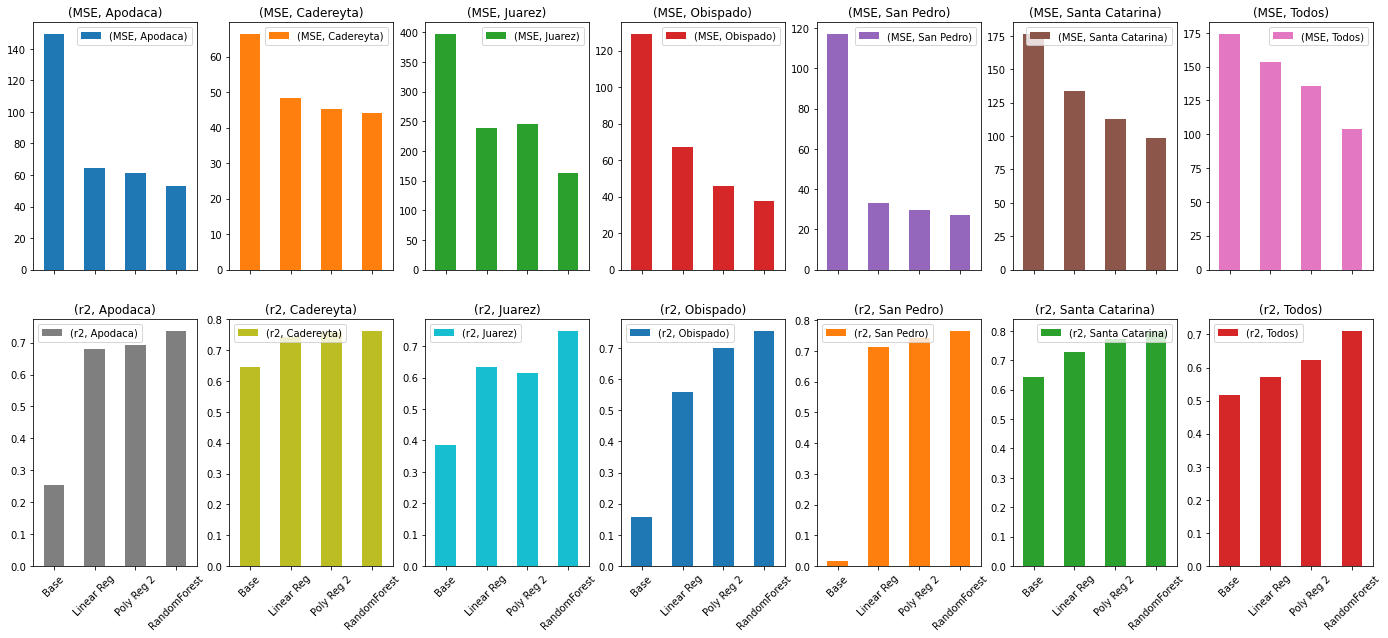

In [20]:
df_res.unstack(level=0).plot(kind='bar', subplots=True, rot=45, figsize=(24, 10), layout=(2,7));